# Inductive `OnDiskDataset` Pipeline

## Tutorial Overview

In this tutorial, we demonstrate how to **implement, configure, run, and test** an inductive on-disk dataset using the `OnDiskDataset` interface from `torch_geometric`.

The tutorial is divided into three main steps:

1. **Implementing an On-Disk Dataset**  
   - Implement data loading and preprocessing logic  
   - Define the key dataset parameters and structure  

2. **Building the Inductive `OnDiskDataset` Pipeline**  
   - Integrate the new dataset into the existing TopoBench pipeline  
   - Ensure smooth interaction with the rest of the framework  

3. **Testing and Memory Tracking**  
   - Compare the performance of `OnDiskDataset` and `InMemoryDataset` pipelines  
   - Measure and visualize memory usage using the `memory_plotting` script

## Implementing an On-Disk Dataset

When working with large datasets, storing all graphs in memory can become inefficient. To address this, PyTorch Geometric provides the `OnDiskDataset` class, which lets us store graphs directly on disk and load them as needed.

Here we show how to implement the core functionality using our own example, `FakeOnDiskDataset`. This dataset generates synthetic graphs (like PyG’s `FakeDataset`) but saves them to disk instead of keeping everything in memory.

To implement your dataset, you **must** override at least two methods from `torch_geometric.data.OnDiskDataset`:

- `download()`: Prepares or fetches the raw data  
- `process()`: Generates and writes processed data to disk in batches  

In addition, override these if your data differs from the defaults or needs special handling (custom fields, optional attributes, non-standard types):

- `serialize()`: How each graph is stored on disk  
- `deserialize()`: How stored graphs are reconstructed when loaded

---

### `download()`

The `download()` method is responsible for fetching or preparing raw data. In our case, since the dataset is generated locally, this method simply ensures that the necessary directories exist.

For real datasets, this is where you would download files, unzip archives, or copy raw data into the `raw/` folder.

---

### `process()`

The `process()` method defines how the dataset is **generated or preprocessed** and then **saved to disk**. Unlike `InMemoryDataset`, which collates all data into memory, `OnDiskDataset` writes data incrementally using the `extend()` method.  

In our example, the method generates random graphs and writes them to disk in small batches:

```python
def process(self) -> None:
    """Generate synthetic graphs and write them to disk in small batches."""
    os.makedirs(self.processed_dir, exist_ok=True)

    batch_size = 1000
    buffer = []

    for i in range(self.num_graphs):
        data = self.generate_data()  # create one graph
        buffer.append(data)

        # Flush to disk every batch or at the very end
        if (i + 1) % batch_size == 0 or (i + 1) == self.num_graphs:
            self.extend(buffer)  # append this batch to the on-disk store
            buffer = []

    print("Processing complete.")

---

### `serialize()` and `deserialize()`

The `serialize()` and `deserialize()` methods define how individual `Data` objects are written to and read from disk. They convert between PyTorch Geometric’s in-memory `Data` format and the dictionary format used for on-disk storage.

You need to override these methods if your dataset includes custom fields or non-standard data types. For simple datasets (`x`, `edge_index`, `y`), the default implementations are already sufficient.

Below is a minimal example from our `FakeOnDiskDataset`:

```python
def serialize(self, data: Data) -> dict[str, object]:
    """Convert a Data object into a dictionary for storage."""
    return {
        "edge_index": data.edge_index,
        "num_nodes":  torch.tensor([data.num_nodes]),
        "x": getattr(data, "x", None),
        "edge_attr": getattr(data, "edge_attr", None),
        "edge_weight": getattr(data, "edge_weight", None),
        "y": getattr(data, "y", None),
    }

When loading data back, `deserialize()` reverses this process: it reconstructs each graph from the stored dictionary:

```python
def deserialize(self, row: dict[str, object]) -> Data:
    """Recreate a Data object from stored tensors."""
    data = Data()
    data.edge_index = row["edge_index"]
    data.num_nodes = int(row["num_nodes"][0])

    # Restore optional attributes
    for key in ("x", "edge_attr", "edge_weight", "y"):
        value = row.get(key)
        if value is not None:
            setattr(data, key, value)

    return data

---

### Configuration Setup

Now that we’ve implemented our on-disk dataset class, we need to define its configuration parameters. The configuration structure is almost identical to the one used for `InMemoryDataset`, but includes a few **on-disk–specific fields** related to how data is stored and accessed.

Below is an example configuration for our `FakeOnDiskDataset`:

```yaml
# Dataset loader configuration
loader:
  _target_: topobench.data.loaders.graph.FakeOnDiskDatasetLoader
  parameters:
    # Framework-specific data organization
    data_domain: graph
    data_type: FakeOnDiskDataset
    data_name: FakeOnDiskDataset
    data_dir: ${paths.data_dir}/${dataset.loader.parameters.data_domain}/${dataset.loader.parameters.data_type}
    memory_type: on_disk          # Key parameter: specifies on-disk data handling
    backend: sqlite               # Storage backend: 'sqlite'
    ...
    
# Dataset parameters
parameters:
  num_features: 64      # Node feature dimension
  num_classes: 5        # Number of label classes
  task: classification
  loss_type: cross_entropy
  monitor_metric: accuracy
  task_level: graph
  ...

The `memory_type` and backend `backend` fields are specific to the on-disk implementation and determine how data is stored and accessed.

## Building the Inductive `OnDiskDataset` Pipeline

With the dataset and configuration in place, the next step is to integrate it into the existing TopoBench pipeline. To keep the framework consistent, we introduce minimal changes that allow seamless switching between **in-memory** and **on-disk** datasets.

In the original pipeline, the preprocessing step is handled by a class called `PreProcessor`. For on-disk datasets, we add a new class`OnDiskPreProcessor` that manages data stored on disk instead of memory.

Inside the main `run` function, the correct preprocessor is chosen dynamically based on the dataset configuration:

```python
def run(cfg: DictConfig) -> DictConfig:
    """Run pipeline with given configuration.
    
    Parameters
    ----------
    cfg : DictConfig
        Configuration.
    """
    # Instantiate and load dataset
    dataset_loader = hydra.utils.instantiate(cfg.dataset.loader)
    dataset, dataset_dir = dataset_loader.load()
    # Preprocess dataset and load the splits
    transform_config = cfg.get("transforms", None)
    memory_type = cfg.dataset.loader.parameters.get("memory_type", "in_memory")
    preprocessor_cls = OnDiskPreProcessor if memory_type == "on_disk" else PreProcessor
    preprocessor = preprocessor_cls(dataset, dataset_dir, transform_config)

The new `OnDiskPreProcessor` reuses the same structure and logic as the standard `PreProcessor`, but adapts data loading and transformation for on-disk storage. It handles datasets that use lazy loading, meaning graphs are loaded from disk only when accessed.

## Testing and Memory Tracking

In this section, we demonstrate how to track and visualize memory usage for the inductive on-disk dataset pipeline using the `memory_plotting` script.

Here’s what happens:
1. The script updates a test template with the selected dataset and model.  
2. It runs the test while tracking memory consumption in real time.  
3. The recorded data is saved to CSV files and converted into a normalized time plot (memory vs. relative progress).

We showcase this on a practical example comparing `graph/fake` and `graph/fake_inmem` across three models:
- `graph/gcn`  
- `cell/topotune`  
- `simplicial/topotune`

In [1]:
# Imports and Utils are handled here.

from pathlib import Path
from contextlib import contextmanager
from IPython.display import Image
import os, sys

sys.path.insert(0, str(Path.cwd().parents[0] / 'tools' / 'memory_usage_tracking'))
import memory_plotting as mp

@contextmanager
def pushd(path: Path):
    prev = Path.cwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(prev)

In [2]:
def run_memory_tracking_demo(
    models=("graph/gcn",),
    datasets=("graph/fake_inmem", "graph/fake"),
    interval=0.05
):
    """
    Runs the memory tracking and returns a plot.
    """
    project_root = Path.cwd().parents[0]
    script_path  = project_root / "test" / "pipeline" / "memory_checks_template.py"
    output_root  = project_root / "test" / "memory_usage_tracking" / "outputs"
    output_root.mkdir(parents=True, exist_ok=True)

    ds1, ds2 = datasets
    ds1_disp = mp.dataset_short(ds1)
    ds2_disp = mp.dataset_short(ds2)

    with pushd(project_root):
        for model in models:
            model_label = model
            model_part  = mp.model_fs(model_label)

            cfg_folder = f"{ds1_disp}__{ds2_disp}__{model_part}"
            config_dir = output_root / cfg_folder
            config_dir.mkdir(parents=True, exist_ok=True)

            csv_outputs_for_model = []
            return_codes = []

            for dataset_disp in (ds1_disp, ds2_disp):
                original_dataset_arg = ds1 if dataset_disp == ds1_disp else ds2
                output_csv = config_dir / f"{model_part}__{dataset_disp}.csv"

                _, rc = mp.monitor_script(
                    script_path=str(script_path),
                    dataset_to_inject=original_dataset_arg,
                    model_to_inject=model_label,
                    output_csv=str(output_csv),
                    interval=interval
                )
                csv_outputs_for_model.append(str(output_csv))
                return_codes.append(rc)
                
            labels = ["InMemoryDataset", "OnDiskDataset"]
            norm_plot_path = str(config_dir / "memory_plot_normalized.png")
            
            mp.plot_normalized_memory(
                model_label,
                csv_outputs_for_model,
                labels=labels,
                plot_path=norm_plot_path,
                colors=("blue", "red")
            )
            
    return Image(filename=norm_plot_path)

### `graph/gcn` model

For the `graph/gcn` model, we run tests on two synthetic datasets `graph/fake` and `graph/fake_inmem`. Both datasets contain **20,000 graphs** with an average of **100 nodes per graph**, but differ in how they are stored and accessed:  
one uses the on-disk format, while the other is kept entirely in memory.  

The plot below shows the memory usage comparison between these two pipelines during execution.

In [3]:
plot = run_memory_tracking_demo(models=("graph/gcn",))

Running for model 'graph/gcn' on dataset 'graph/fake_inmem'
============================= test session starts ==============================
platform darwin -- Python 3.11.3, pytest-8.4.2, pluggy-1.6.0
rootdir: /Users/davidleko/Desktop/Projects/TopoBench
configfile: pyproject.toml
plugins: mock-3.15.1, anyio-4.11.0, hydra-core-1.3.2, cov-7.0.0
collected 1 item

test/pipeline/tmpwshvgyjw.py 

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | feature_encoder | AllCellFeatureEncoder | 8.5 K  | train
1 | backbone        | GNNWrapper            | 8.4 K  | train
2 | readout         | NoReadOut             | 325    | train
3 | val_acc_best    | MeanMetric            | 0      | train
------------------------------------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


20000
tensor([3])
[3 0 3 ... 4 4 4] (20000,)
Epoch 0: 100%|██████████| 500/500 [00:12<00:00, 38.62it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 500/500 [00:12<00:00, 39.15it/s, train/accuracy=0.891, train/auroc=0.964, train/precision=0.891, train/recall=0.891, val/loss=0.0047, val/accuracy=1.000, val/auroc=1.000, val/precision=1.000, val/recall=1.000, train/loss=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Testing DataLoader 0:  14%|█▍        | 9/63 [00:00<00:00, 90.95it/s] 

`Trainer.fit` stopped: `max_epochs=2` reached.
Restoring states from the checkpoint path at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_000-v224.ckpt
Loaded model weights from the checkpoint at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_000-v224.ckpt


Testing DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 89.97it/s]
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9995002746582031     │
│        test/auroc         │            1.0            │
│         test/loss         │   0.0045613874681293964   │
│      test/precision       │    0.9994845390319824     │
│        test/recall        │    0.9995260834693909     │
└───────────────────────────┴───────────────────────────┘
.

=============================== warnings summary ===============================
test/pipeline/tmpwshvgyjw.py::TestPipeline::test_pipeline
  /Users/davidleko/Desktop/Projects/TopoBench/test/pipeline/tmpwshvgyjw.py:16: UserWarning: 
  The version_base parameter is not specified.
  Please specify a compatability version level, or None.
  Will assume defaults for version 1.1
    with hydra.initialize(conf

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | feature_encoder | AllCellFeatureEncoder | 8.5 K  | train
1 | backbone        | GNNWrapper            | 8.4 K  | train
2 | readout         | NoReadOut             | 325    | train
3 | val_acc_best    | MeanMetric            | 0      | train
------------------------------------------------------------------
17.3 K    Trainable params
0         Non-trainable params
17.3 K    Total params
0.069     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


Finished.
20000
tensor([4])
Epoch 0: 100%|██████████| 500/500 [00:13<00:00, 36.31it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 500/500 [00:13<00:00, 36.09it/s, train/accuracy=0.875, train/auroc=0.967, train/precision=0.875, train/recall=0.875, val/loss=0.00614, val/accuracy=1.000, val/auroc=1.000, val/precision=1.000, val/recall=1.000, train/loss=0.993]
Validation: |          | 0/? [00:00<?, ?it/s]
Testing DataLoader 0:  14%|█▍        | 9/63 [00:00<00:00, 54.21it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
Restoring states from the checkpoint path at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_000-v225.ckpt
Loaded model weights from the checkpoint at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_000-v225.ckpt


Testing DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 71.75it/s]
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │            1.0            │
│        test/auroc         │            1.0            │
│         test/loss         │   0.006208824925124645    │
│      test/precision       │            1.0            │
│        test/recall        │            1.0            │
└───────────────────────────┴───────────────────────────┘
.

=============================== warnings summary ===============================
test/pipeline/tmpfpmr5c9r.py::TestPipeline::test_pipeline
  /Users/davidleko/Desktop/Projects/TopoBench/test/pipeline/tmpfpmr5c9r.py:16: UserWarning: 
  The version_base parameter is not specified.
  Please specify a compatability version level, or None.
  Will assume defaults for version 1.1
    with hydra.initialize(conf

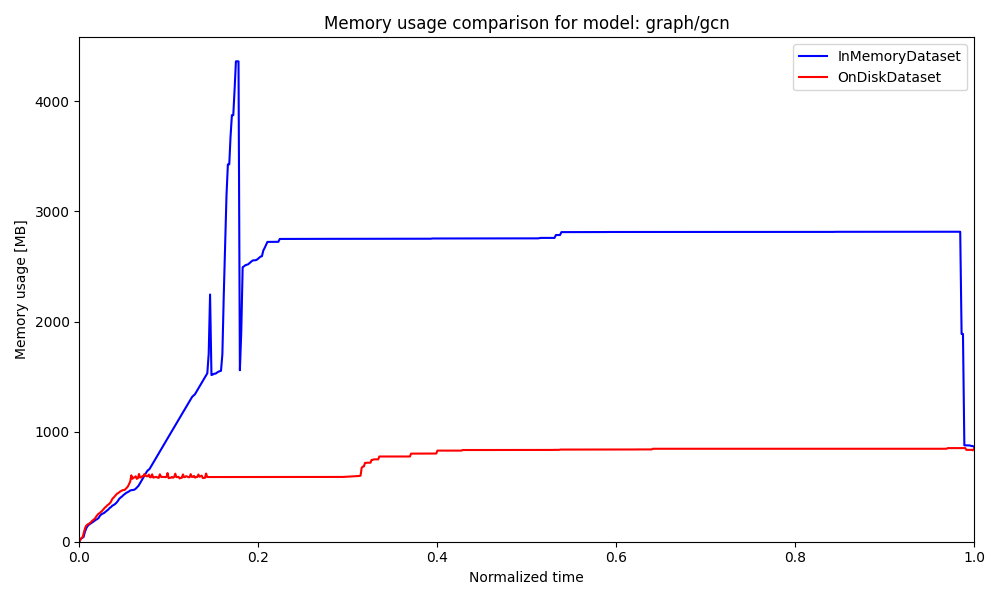

In [4]:
plot

### `cell/topotune` model

For the `cell/topotune` model, we test the pipeline using datasets that contain **5,000 graphs** with an average of **100 nodes per graph**. In this case, the `OnDiskPreProcessor` performs computationally intensive topology liftings as an initial step.

This setup demonstrates how the on-disk pipeline handles heavier preprocessing workloads.

In [5]:
plot = run_memory_tracking_demo(models=("cell/topotune",))

Running for model 'cell/topotune' on dataset 'graph/fake_inmem'
============================= test session starts ==============================
platform darwin -- Python 3.11.3, pytest-8.4.2, pluggy-1.6.0
rootdir: /Users/davidleko/Desktop/Projects/TopoBench
configfile: pyproject.toml
plugins: mock-3.15.1, anyio-4.11.0, hydra-core-1.3.2, cov-7.0.0
collected 1 item

test/pipeline/tmp5o2iftqu.py 

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | feature_encoder | AllCellFeatureEncoder | 9.7 K  | train
1 | backbone        | TuneWrapper           | 17.6 K | train
2 | readout         | PropagateSignalDown   | 6.5 K  | train
3 | val_acc_best    | MeanMetric            | 0      | train
------------------------------------------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


5000
tensor([3])
[3 4 4 ... 3 3 0] (5000,)
Epoch 0: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s, train/accuracy=0.438, train/auroc=0.723, train/precision=0.436, train/recall=0.438, val/loss=0.562, val/accuracy=0.671, val/auroc=0.988, val/precision=0.805, val/recall=0.675, train/loss=3.890]
Validation: |          | 0/? [00:00<?, ?it/s]
Testing DataLoader 0:   0%|          | 0/16 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
Restoring states from the checkpoint path at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_001-v247.ckpt
Loaded model weights from the checkpoint at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_001-v247.ckpt


Testing DataLoader 0: 100%|██████████| 16/16 [00:03<00:00,  5.20it/s]
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9980040192604065     │
│        test/auroc         │            1.0            │
│         test/loss         │    0.09594758599996567    │
│      test/precision       │    0.9978947043418884     │
│        test/recall        │    0.9979381561279297     │
└───────────────────────────┴───────────────────────────┘
.

=============================== warnings summary ===============================
test/pipeline/tmp5o2iftqu.py::TestPipeline::test_pipeline
  /Users/davidleko/Desktop/Projects/TopoBench/test/pipeline/tmp5o2iftqu.py:16: UserWarning: 
  The version_base parameter is not specified.
  Please specify a compatability version level, or None.
  Will assume defaults for version 1.1
    with hydra.initialize(conf

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | feature_encoder | AllCellFeatureEncoder | 9.7 K  | train
1 | backbone        | TuneWrapper           | 17.6 K | train
2 | readout         | PropagateSignalDown   | 6.5 K  | train
3 | val_acc_best    | MeanMetric            | 0      | train
------------------------------------------------------------------
33.8 K    Trainable params
0         Non-trainable params
33.8 K    Total params
0.135     Total estimated model params size (MB)
156       Modules in train mode
0         Modules in eval mode


Finished.
5000
tensor([1])
Epoch 0: 100%|██████████| 125/125 [01:01<00:00,  2.04it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 125/125 [01:01<00:00,  2.03it/s, train/accuracy=0.458, train/auroc=0.725, train/precision=0.455, train/recall=0.456, val/loss=0.397, val/accuracy=0.874, val/auroc=0.992, val/precision=0.896, val/recall=0.871, train/loss=4.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 125/125 [01:05<00:00,  1.90it/s, train/accuracy=0.943, train/auroc=0.994, train/precision=0.941, train/recall=0.941, val/loss=0.102, val/accuracy=0.998, val/auroc=1.000, val/precision=0.998, val/recall=0.998, train/loss=0.230]
Testing: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
Restoring states from the checkpoint path at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_001-v248.ckpt
Loaded model weights from the checkpoint at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_001-v248.ckpt


Testing DataLoader 0: 100%|██████████| 16/16 [00:04<00:00,  3.97it/s]
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9940119981765747     │
│        test/auroc         │    0.9999898076057434     │
│         test/loss         │    0.11406886577606201    │
│      test/precision       │    0.9941577911376953     │
│        test/recall        │    0.9940835237503052     │
└───────────────────────────┴───────────────────────────┘
.

=============================== warnings summary ===============================
test/pipeline/tmp7a3eppd6.py::TestPipeline::test_pipeline
  /Users/davidleko/Desktop/Projects/TopoBench/test/pipeline/tmp7a3eppd6.py:16: UserWarning: 
  The version_base parameter is not specified.
  Please specify a compatability version level, or None.
  Will assume defaults for version 1.1
    with hydra.initialize(conf

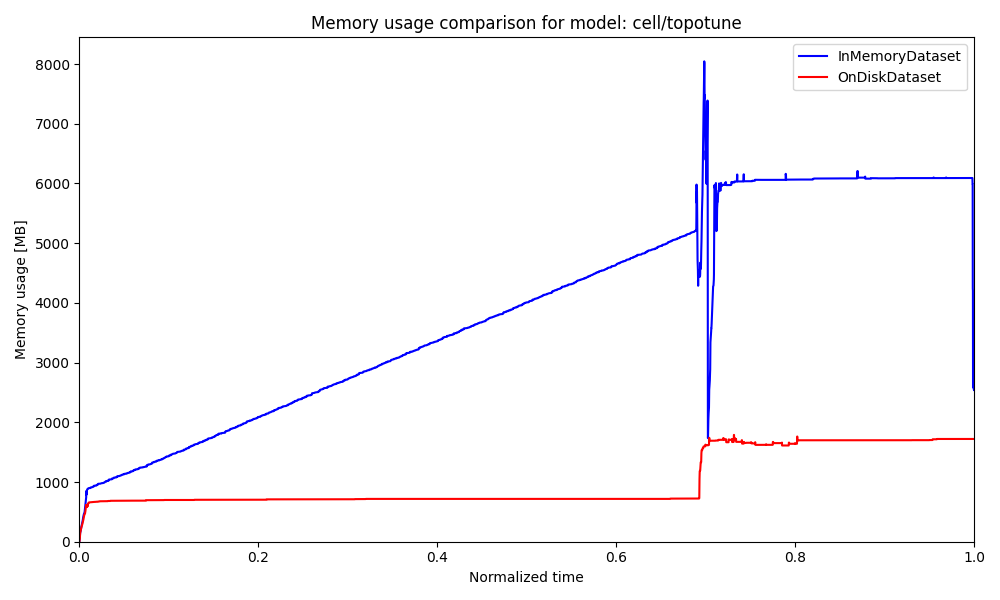

In [6]:
plot

### `simplicial/topotune` model

For the `simplicial/topotune` model, we use the same dataset configuration: **5,000 graphs** with an average of **100 nodes per graph**.

In [9]:
plot = run_memory_tracking_demo(models=("simplicial/topotune",))

Running for model 'simplicial/topotune' on dataset 'graph/fake_inmem'
============================= test session starts ==============================
platform darwin -- Python 3.11.3, pytest-8.4.2, pluggy-1.6.0
rootdir: /Users/davidleko/Desktop/Projects/TopoBench
configfile: pyproject.toml
plugins: mock-3.15.1, anyio-4.11.0, hydra-core-1.3.2, cov-7.0.0
collected 1 item

test/pipeline/tmp7sd2ronn.py 

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | feature_encoder | AllCellFeatureEncoder | 9.7 K  | train
1 | backbone        | TuneWrapper           | 35.5 K | train
2 | readout         | PropagateSignalDown   | 6.5 K  | train
3 | val_acc_best    | MeanMetric            | 0      | train
------------------------------------------------------------------
51.7 K    Trainable params
0         Non-trainable params
51.7 K    Total params
0.207     Total estimated model params size (MB)
252       Modules in train mode
0         Modules in eval mode


5000
tensor([3])
[3 4 1 ... 3 3 3] (5000,)
Epoch 0: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s, train/accuracy=0.517, train/auroc=0.756, train/precision=0.516, train/recall=0.519, val/loss=0.390, val/accuracy=0.862, val/auroc=0.994, val/precision=0.880, val/recall=0.873, train/loss=3.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Testing DataLoader 0:   6%|▋         | 1/16 [00:00<00:01, 11.82it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
Restoring states from the checkpoint path at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_001-v249.ckpt
Loaded model weights from the checkpoint at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_001-v249.ckpt


Testing DataLoader 0: 100%|██████████| 16/16 [00:01<00:00, 11.28it/s]
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9800398945808411     │
│        test/auroc         │    0.9999658465385437     │
│         test/loss         │    0.13319484889507294    │
│      test/precision       │    0.9808529615402222     │
│        test/recall        │    0.9805454611778259     │
└───────────────────────────┴───────────────────────────┘
.

=============================== warnings summary ===============================
test/pipeline/tmp7sd2ronn.py::TestPipeline::test_pipeline
  /Users/davidleko/Desktop/Projects/TopoBench/test/pipeline/tmp7sd2ronn.py:16: UserWarning: 
  The version_base parameter is not specified.
  Please specify a compatability version level, or None.
  Will assume defaults for version 1.1
    with hydra.initialize(conf

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | feature_encoder | AllCellFeatureEncoder | 9.7 K  | train
1 | backbone        | TuneWrapper           | 35.5 K | train
2 | readout         | PropagateSignalDown   | 6.5 K  | train
3 | val_acc_best    | MeanMetric            | 0      | train
------------------------------------------------------------------
51.7 K    Trainable params
0         Non-trainable params
51.7 K    Total params
0.207     Total estimated model params size (MB)
252       Modules in train mode
0         Modules in eval mode


Finished.
5000
tensor([3])
Epoch 0: 100%|██████████| 125/125 [00:29<00:00,  4.18it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 125/125 [00:29<00:00,  4.17it/s, train/accuracy=0.389, train/auroc=0.671, train/precision=0.388, train/recall=0.388, val/loss=0.779, val/accuracy=0.639, val/auroc=0.948, val/precision=0.753, val/recall=0.643, train/loss=3.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Testing DataLoader 0:   6%|▋         | 1/16 [00:00<00:01, 10.20it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
Restoring states from the checkpoint path at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_001-v250.ckpt
Loaded model weights from the checkpoint at /Users/davidleko/Desktop/Projects/TopoBench/outputs/checkpoints/epoch_001-v250.ckpt


Testing DataLoader 0: 100%|██████████| 16/16 [00:01<00:00,  8.23it/s]
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9500998258590698     │
│        test/auroc         │     0.999347984790802     │
│         test/loss         │    0.2502969801425934     │
│      test/precision       │      0.9530029296875      │
│        test/recall        │    0.9518786668777466     │
└───────────────────────────┴───────────────────────────┘
.

=============================== warnings summary ===============================
test/pipeline/tmpxhjlrnxu.py::TestPipeline::test_pipeline
  /Users/davidleko/Desktop/Projects/TopoBench/test/pipeline/tmpxhjlrnxu.py:16: UserWarning: 
  The version_base parameter is not specified.
  Please specify a compatability version level, or None.
  Will assume defaults for version 1.1
    with hydra.initialize(conf

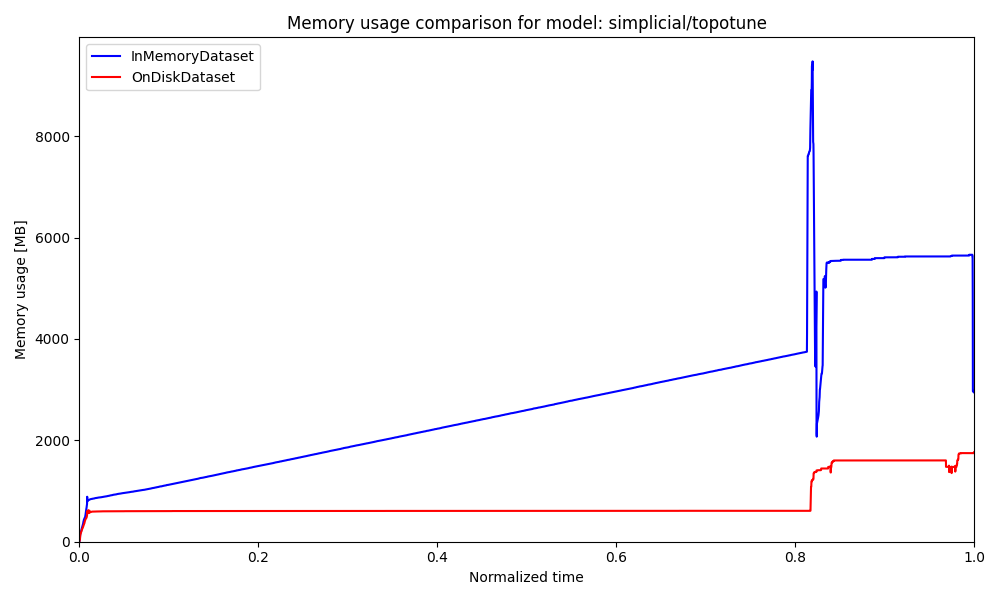

In [10]:
plot

## Cleanup and Further Use

Before running new experiments or regenerating datasets, we recommend removing previously created folders to ensure a clean setup. This prevents conflicts with cached data, outdated splits, or previously processed files.

You can safely remove the old datasets and data split directories using:

```bash
rm -rf datasets/graph/dataset_name
rm -rf datasets/data_splits/dataset_name